# This notebook

This notebook contains first bits and pieces of the yet to be developed model correlating climate/environmental factors with conflict occurrence.

This notbook is under constant development. Please be aware of the version number of the conflict model used in each of the notebooks.

In its current form, we first make a selection of conflicts to be used for training and testing the model. Selection criteria are amongst others minimum number of fatalities and climate zones. Subsequently, annual statistics (now: mean) of a range of environmental variables are determined per geographic unit (now: water provinces) and stored along with a 0/1 conflict value. This dataset is then scaled, split, and applied in a machine learning model (now: support vector classification).

All model settings need to be defined in the run_settings.cfg file.

## Import libraries and file with settings

Import all required python packages for this notebook.

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv
import netCDF4 as nc
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import seaborn as sbs
from sklearn import svm, neighbors, naive_bayes, preprocessing, model_selection, metrics
from shutil import copyfile, rmtree
import os, sys

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.2b3
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


Geopandas versions lower than 0.7.0 do not yet have the clip function. The notebook will thus not work with these versions.

In [3]:
if gpd.__version__ < '0.7.0':
    sys.exit('please upgrade geopandas to version 0.7.0, your current version is {}'.format(gpd.__version__))

In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [4]:
settings_file = r'../data/run_setting.cfg'

In [5]:
config = RawConfigParser(allow_no_value=True)
config.optionxform = lambda option: option
config.read(settings_file);

Create the output folder as specified in the settings, in case it does not exist yet.

In [6]:
out_dir = os.path.abspath(config.get('general','output_dir'))
# if not os.path.isdir(out_dir):
#         os.makedirs(out_dir)
if os.path.isdir(out_dir):
    rmtree(out_dir)
os.makedirs(out_dir)
print('for the record, saving output to folder {}'.format(out_dir))

for the record, saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT


Make a copy of the settings file in the output file to always get an idea on what settings the output is based.

In [7]:
copyfile(settings_file, os.path.join(out_dir, 'copy_of_run_setting.cfg'));

# Applying functions

First, get the conflict data base and convert it into a georeferenced dataframe. This is needed for all following steps where this data is combined with other data sources.

In [8]:
gdf = conflict_model.utils.get_geodataframe(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP/ged191.csv
...DONE

translating to geopandas dataframe
...DONE



Second, get the subset of conflicts based on user-defined conditions in the settings file.

In [9]:
conflict_gdf, extent_gdf = conflict_model.selection.select(gdf, config)

filtering on conflict properties...
...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty
focussing on period between 2000 and 2015

reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp
...DONE

clipping datasets to extent
...DONE

clipping to climate zones['BWh', 'BSh']
...DONE



# Functions

Add functions to be tested here.

# Analysis per year

This is the core of the code. Here, we go through all model years as specified in the settings-file and do the following:

1. Get a 0/1 classifier whether a conflict took place in a geographical unit or not;
2. Loop through various files with environmental variables and get mean variable value per geographical unit.

This is all stored in a dictionary for easy processing. We first need to initialize this dictionary containing a pandas Series per provided environmental variable. Then, add a pandas Series for the conflict data.

In [10]:
XY = {}
for key in config.items('env_vars'):
    XY[str(key[0])] = pd.Series(dtype=float)
XY['conflict'] = pd.Series(dtype=int)
XY

{'GDP_per_capita_PPP': Series([], dtype: float64),
 'total_evaporation': Series([], dtype: float64),
 'precipitation': Series([], dtype: float64),
 'surface_water_storage': Series([], dtype: float64),
 'upper_soil_storage': Series([], dtype: float64),
 'groundwater_recharge': Series([], dtype: float64),
 'temperature': Series([], dtype: float64),
 'int_grazing': Series([], dtype: float64),
 'ext_grazing': Series([], dtype: float64),
 'conflict': Series([], dtype: int32)}

Now let's go through all years and all files and data and assign the values to the corresponding Series in the dictionary.

In [11]:
%%capture

print('simulation period from', str(config.getint('settings', 'y_start')), 'to', str(config.getint('settings', 'y_end')))
print('')

# go through all simulation years as specified in config-file
for sim_year in np.arange(config.getint('settings', 'y_start'), config.getint('settings', 'y_end'), 1):
    
    print('entering year {}'.format(sim_year) + os.linesep)
    
    # go through all keys in dictionary
    for key, value in XY.items():
        
        if key == 'conflict':
            data_series = value
            data_list = conflict_model.get_boolean_conflict.conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year)
            data_series = data_series.append(pd.Series(data_list), ignore_index=True)
            XY[key] = data_series
            
        else:
            nc_fo = os.path.join(config.get('general', 'input_dir'), 
                                 config.get('env_vars', key))
            
            print('calculating mean {0} per aggregation unit from file {1} for year {2}'.format(key, nc_fo, sim_year))

            nc_ds = xr.open_dataset(nc_fo)
            
            if (np.dtype(nc_ds.time) == np.float32) or (np.dtype(nc_ds.time) == np.float64):
                data_series = value
                data_list = conflict_model.get_var_from_nc.nc_with_float_timestamp(extent_gdf, config, key, sim_year)
                data_series = data_series.append(pd.Series(data_list), ignore_index=True)
                XY[key] = data_series
                
            elif np.dtype(nc_ds.time) == 'datetime64[ns]':
                data_series = value
                data_list = conflict_model.get_var_from_nc.nc_with_continous_datetime_timestamp(extent_gdf, config, key, sim_year)
                data_series = data_series.append(pd.Series(data_list), ignore_index=True)
                XY[key] = data_series
                
            else:
                raise Warning('this nc-file does have a different dtype for the time variable than currently supported: {}'.format(nc_fo))
                
print('...simulation DONE')

# Machine Learning

## Data preparation

First, create a pandas dataframe from the dictionary and kick out rows with missing values (they do not work with ML)

In [12]:
XY = pd.DataFrame.from_dict(XY)
print('number of data points including missing values:', len(XY))
XY = XY.dropna()
print('number of data points excluding missing values:', len(XY))

number of data points including missing values: 5790
number of data points excluding missing values: 5760


Then, convert them to numpy arrays, separately for the variables (X) and the target conflict (Y).

In [13]:
X = XY.to_numpy()[:, :-1] # since conflict is the last column, we know that all previous columns must be variable values
X

array([[2.36193426e+03, 4.23162297e-02, 5.90158959e-02, ...,
        1.69482798e+01, 4.27550003e-02, 4.27550003e-02],
       [3.10405169e+03, 4.05202232e-02, 4.38823540e-02, ...,
        2.62989597e+01, 4.27103449e-02, 4.27103449e-02],
       [1.19202521e+03, 3.92765536e-02, 3.85574701e-02, ...,
        2.41465799e+01, 4.27550003e-02, 4.27550003e-02],
       ...,
       [1.70019058e+03, 4.56631968e-02, 7.90373737e-02, ...,
        1.99556426e+01, 2.07449999e-02, 2.07449999e-02],
       [1.71027506e+03, 4.38179032e-02, 5.47764229e-02, ...,
        2.20619215e+01, 2.07449999e-02, 2.07449999e-02],
       [1.71202357e+03, 5.35152570e-02, 5.75030690e-02, ...,
        2.21496095e+01, 2.07449999e-02, 2.07449999e-02]])

In [14]:
Y = XY.conflict.astype(int).to_numpy()
Y

array([0, 0, 0, ..., 0, 0, 0])

### Target evaluation

Let's have a closer look at what we actualy work with. This is essential to select and tune the right ML model, for instance.

In [15]:
print('the total number of data points for our target is', len(Y))

the total number of data points for our target is 5760


In [16]:
print('from this, {0} points are equal to 1, i.e. represent conflict occurence. This is a fraction of {1} percent.'.format(len(np.where(Y != 0)[0]), round(100*len(np.where(Y != 0)[0])/len(Y), 2)))

from this, 310 points are equal to 1, i.e. represent conflict occurence. This is a fraction of 5.38 percent.


This small fraction indicated we have an **imbalanced problem** and thus will need to account for this in the settings of the model used and data pre-processing.

## Data pre-processing

Before we can train and predict with the model, we need to scale the variable data and create trainings and test data for both variables and target.

There are different scaling algorithms available. For our application, the MinMaxScaler and StandardScaler are the most obvious choices, the RobustScaler is follow-up. Depending on how incoming data looks like and is distributed, the scaling decision may need to be updated.

Depending on which scaler is chosen, the standardization of the data follows different approaches and may eventually influence model results. See here for some info: https://scikit-learn.org/stable/modules/preprocessing.html and https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html.

In [17]:
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.StandardScaler()
# scaler = preprocessing.RobustScaler()
scaler = preprocessing.QuantileTransformer()

The scaler is then used to fit the data and transform it according to scaler-specific method. I don't scale Y since it is either 0 or 1 already.

In [18]:
X_scaled = scaler.fit_transform(X)

The scaled variable data X_scaled is, together with the target data Y, split into trainings and test data. The fraction of the total data that is used for training is user-defined.

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled,
                                                                    Y,
                                                                    test_size=1-config.getfloat('machine_learning', 'train_fraction'))

The scatterplot of the first two variables in X_train looks like this. Also the sample size n_train is provided used to train the data alongside with the total variable sample size n_tot.

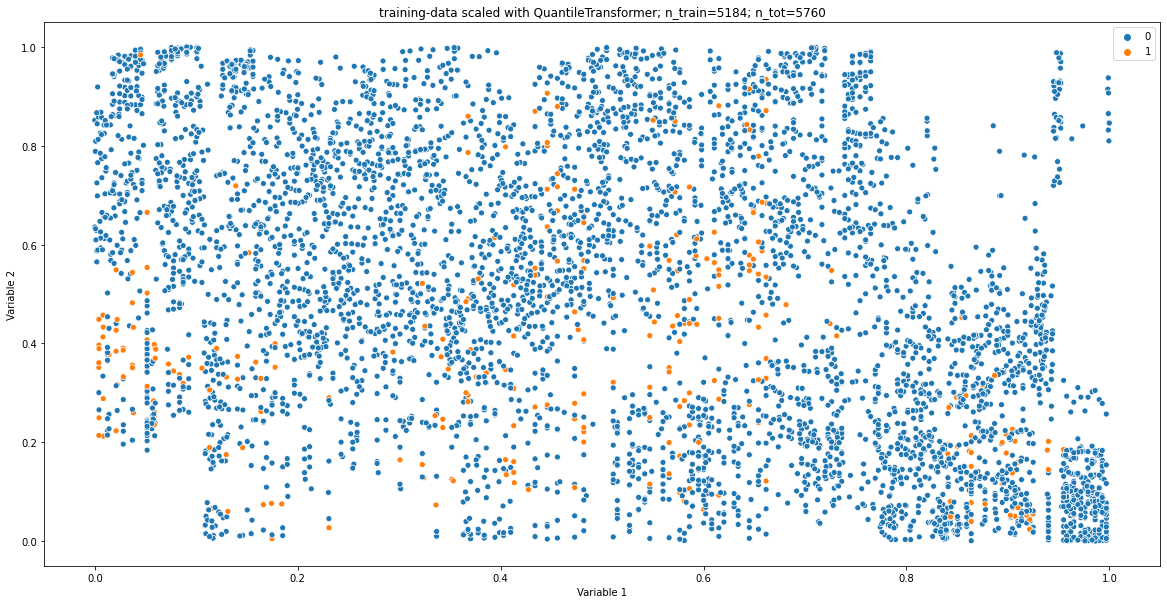

In [20]:
plt.figure(figsize=(20,10))
sbs.scatterplot(x=X_train[:,0],
                y=X_train[:,1],  
                hue=y_train)

plt.title('training-data scaled with {0}; n_train={1}; n_tot={2}'.format(str(scaler).rsplit('(')[0], len(X_train), len(X_scaled)))
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.savefig(os.path.join(out_dir, 'scatter_plot_scaled_traindata_{}.png'.format(str(scaler).rsplit('(')[0])), dpi=300)

A brief look at the statistics of the data of our scaled and standardized variables.

In [21]:
X_scaled.mean(axis=0), X_scaled.std(axis=0)

(array([0.50001379, 0.50000215, 0.49999846, 0.49997511, 0.50000012,
        0.49999594, 0.50000184, 0.50001759, 0.50001759]),
 array([0.28874004, 0.28872487, 0.28872706, 0.28875994, 0.28872483,
        0.28872383, 0.28872317, 0.28880775, 0.28880775]))

## Model

### Train and predict

There are many ML models to choose from. Our first pick were SVCs, but also KNN or NB are possible for supervised learning. Here we can define a range of models which will be tested further down the notebook.

Some findings made thus far:

* LinearSVC underperform comapred to SVC and NuSVC
* CategoricalNB does not work

Since we have an **imbalanced problem**, we can define weights to make (some) ML models where this is applicable more accurate.

In [22]:
class_weight = {1: 100}

Now specify models and add them to list 'clfs'.

In [23]:
##- SVC performing very comparable with NuSVC yet slightly worse, so we drop it
#clf1 = svm.SVC(class_weight=class_weight, kernel='rbf', random_state=42, probability=True)

In [24]:
clf2 = svm.NuSVC(nu=0.1, kernel='rbf', class_weight=class_weight, random_state=42, probability=True, degree=10, gamma=10)

In [25]:
##- LinearSVC is underperforming compared with other models, so we drop it
#clf3 = svm.LinearSVC(class_weight=class_weight, random_state=42, max_iter=10000000)

In [121]:
clf4 = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')

In [122]:
clf5 = naive_bayes.GaussianNB()

In [123]:
##- MultinomialNB are not as accurate as GaussianNB, so we drop it
# clf6 = naive_bayes.MultinomialNB()

In [124]:
clfs = [
#    clf1,
    clf2,
#    clf3,
    clf4,
    clf5,
#     clf6,
]

### k-fold cross-validation

It is important to check how robust the accuracy of the models are in terms of accuracy as well as under- and overfitting. To that end, we apply **cross-validation (CV)** to fit the training-data against each other by splitting it up in chunks (as defined by k) and one chunk against all other k-1 chunks.

Note: the NuSVC model and kNN is already calibrated using GridSearchCV, ie results are not entirely comparable between models!

In [125]:
CV = []
k = 10

for clf in clfs:
    accuracy = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=k)
    CV.append(accuracy.mean())
    
print('the average k-fold cross-validation scores with k={} for the individual clfs are {}'.format(k, CV))

the average k-fold cross-validation scores with k=10 for the individual clfs are [0.9535091243183729, 0.9538944807730934, 0.8485738835449818]


Based on these results, it seems that the following model has the lowest average accuracy:

In [126]:
clfs[np.where(CV==np.min(CV))[0][0]]

GaussianNB(priors=None, var_smoothing=1e-09)

While the model with the highest average accuracy is this model:

In [127]:
clfs[np.where(CV==np.max(CV))[0][0]]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

### Model fitting and prediction

Now we know that and can continue to fit our models based on the trainig-data and subsequently predict our target based on the remaining test-data.

In [128]:
predictions = []
scores = []

for clf in clfs:
    # Fit the model with the scaled training data and the boolean conflict data
    clf.fit(X_train, y_train)
    # Predict with the scaled prediction data
    y_pred = clf.predict(X_test)
    # Determine score
    try:
        y_score = clf.decision_function(X_test)
    except:
        y_score = np.nan
    # Append
    predictions.append(y_pred)
    scores.append(y_score)

### Evaluation

We have now produced a set of predictions, y_pred. This can be comapred with the retained test-targets y_test to evaluate the prediction. There are many ways to do this and several are applied here.

The **accuracy** is either the fraction (default) or the count (normalize=False) of correct predictions.

The **precision** is the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The main classification metrics are nicely summarized in the **classification report**:

**Precision-Recall** is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Another nice way to vizualize the accuracy of our results is the **confusion matrix**. The confusion_matrix function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

Yet another metric is the **Brier score** (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss). The smaller the Brier score, the better, hence the naming with “loss”. Across all items in a set N predictions, the Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome. Therefore, the lower the Brier score is for a set of predictions, the better the predictions are calibrated

Last but not least, the **F1 score**, also known as balanced F-score or F-measure. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1%20score#sklearn.metrics.f1_score)

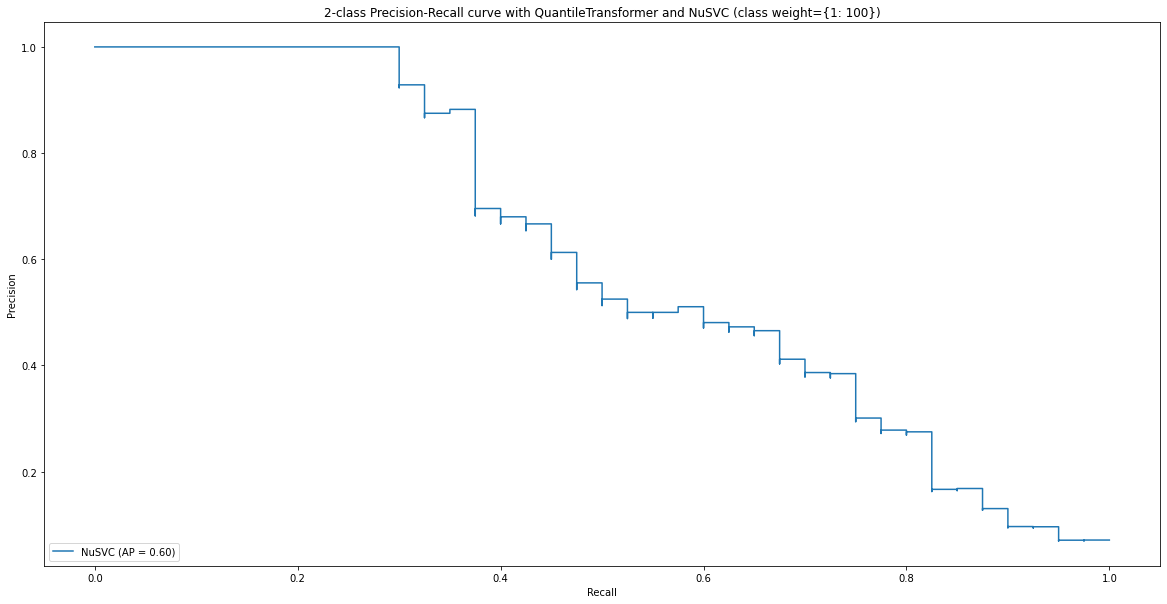

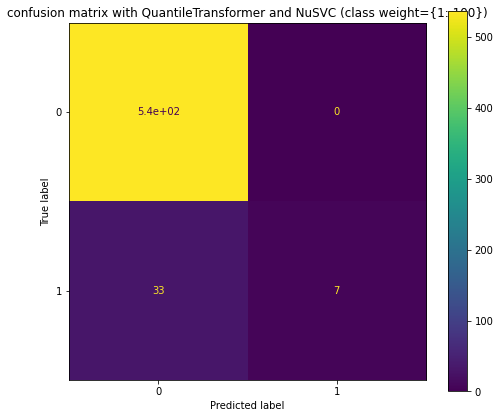

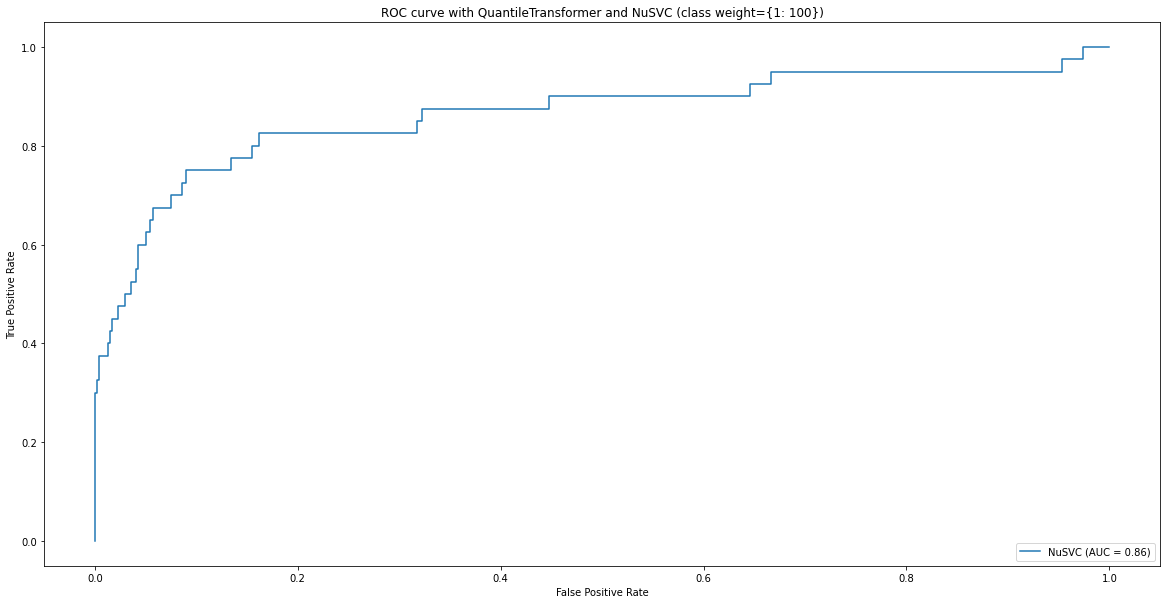

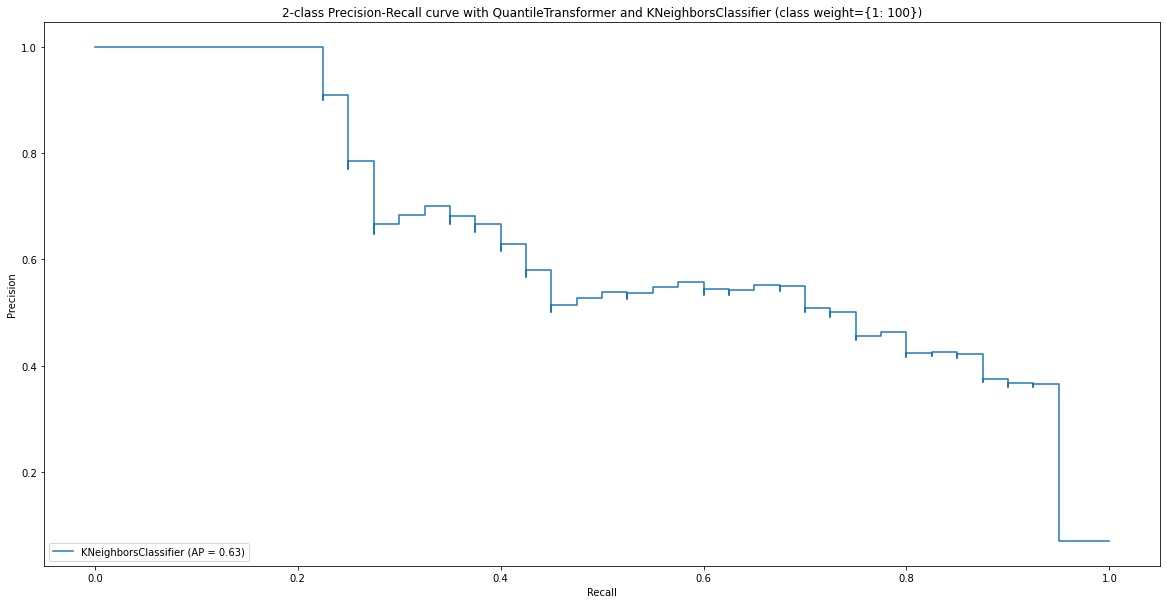

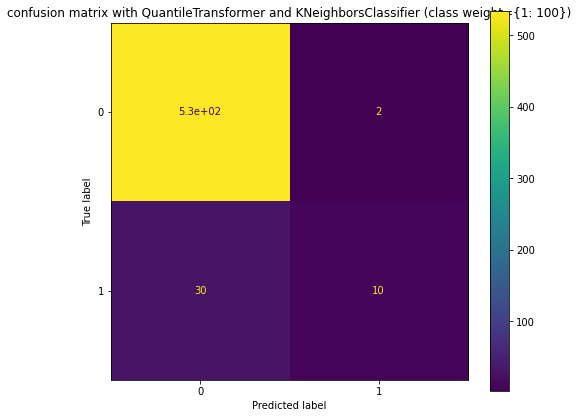

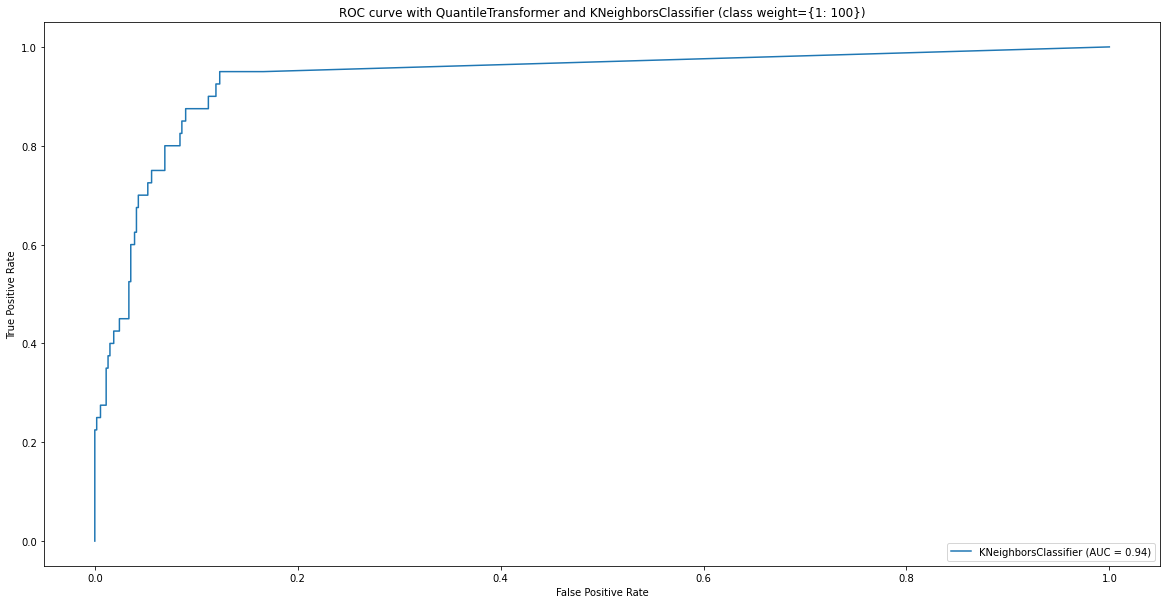

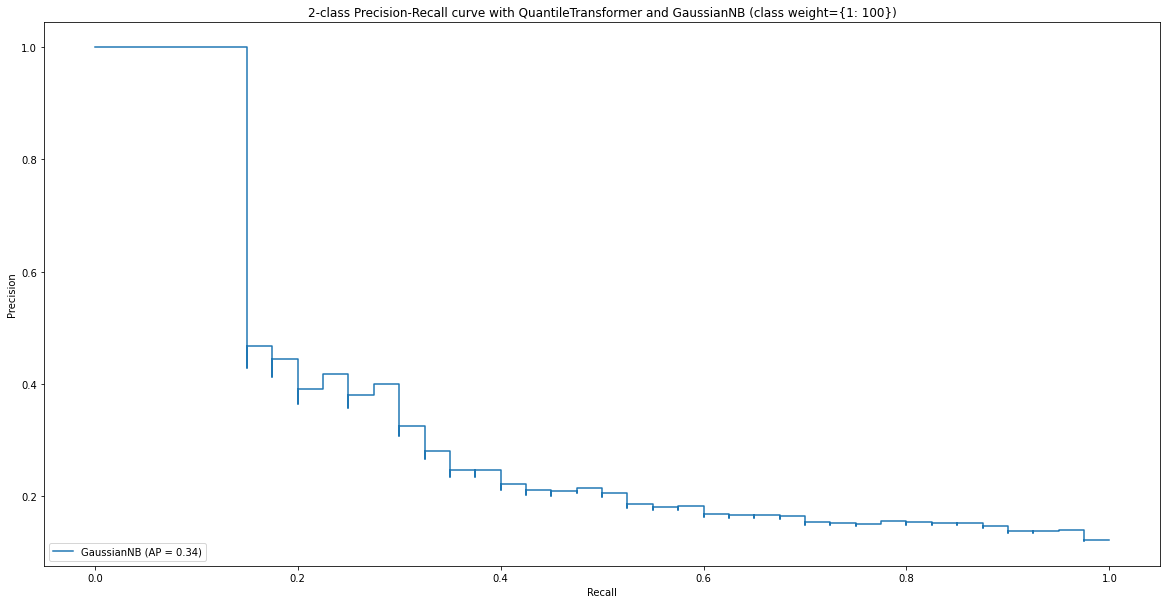

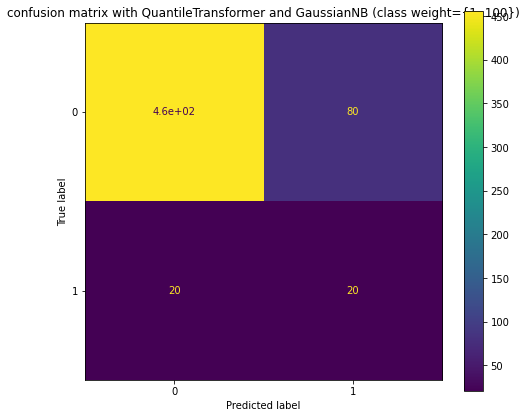

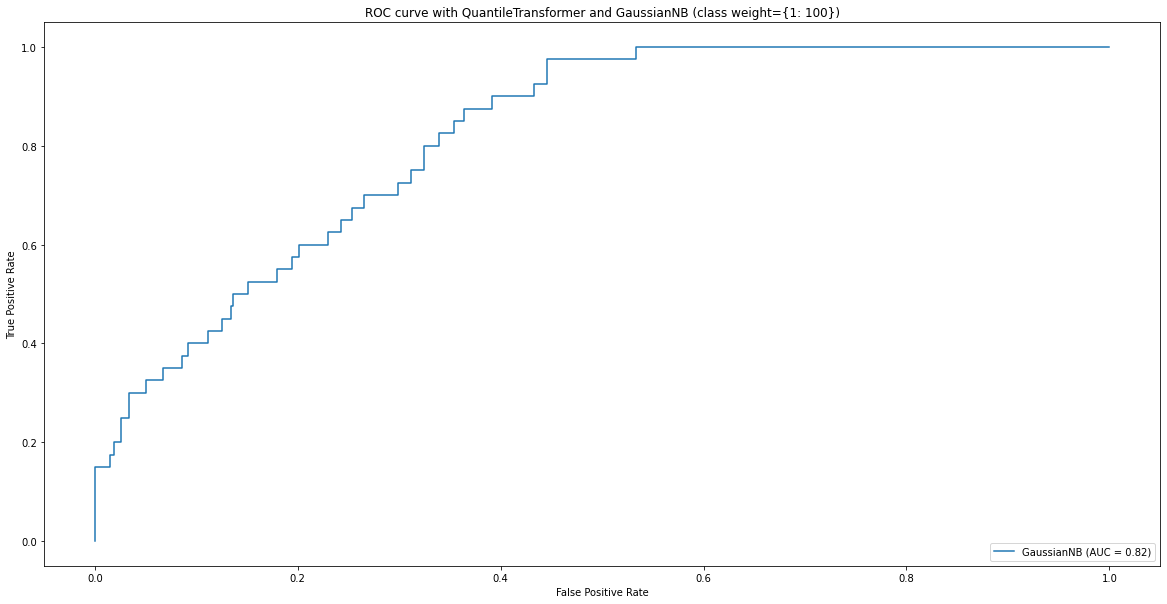

In [129]:
orig_stdout = sys.stdout
f = open(os.path.join(out_dir, 'out.txt'), 'w')
sys.stdout = f

AP = []
F1_score = []
ROC = []

for pred, score, clf in zip(predictions, scores, clfs):

    # Evaluate
    print(clf)
    print("Accuracy:", metrics.accuracy_score(y_test, pred))
    print("Precision:", metrics.precision_score(y_test, pred))
    print("Recall:", metrics.recall_score(y_test, pred))
    
    print(metrics.classification_report(y_test, pred))
    
    try:
        average_precision = metrics.average_precision_score(y_test, score)
        print('Average precision-recall score: {0:0.2f}'.format(average_precision))
        AP.append(average_precision)
    except:
        print('Average precision-recall score could not be computed')
        pass  
    
    print('Brier score: to be implemented!')
    
    try:
        print('ROC score: {0:0.2f}'.format(metrics.roc_auc_score(y_test, score)))
        ROC.append(metrics.roc_auc_score(y_test, score))
    except:
        print('ROC score could not be computed')
        pass
    
    print('F1 score: {0:0.2f}'.format(metrics.f1_score(y_test, pred)))
    F1_score.append(metrics.f1_score(y_test, pred))
    
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax)
    disp.ax_.set_title('2-class Precision-Recall curve with {} and {} (class weight={})'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0], class_weight))
    plt.savefig(os.path.join(out_dir, 'precision_recall_curve_{}+{}.png'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0])), dpi=300)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 7))
    ax.set_title('confusion matrix with {} and {} (class weight={})'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0], class_weight))
    metrics.plot_confusion_matrix(clf, X_test, y_test, ax=ax)
    plt.savefig(os.path.join(out_dir, 'confusion_matrix_{}+{}.png'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0])), dpi=300)
    
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    ax.set_title('ROC curve with {} and {} (class weight={})'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0], class_weight))
    metrics.plot_roc_curve(clf, X_test, y_test, ax=ax)
    plt.savefig(os.path.join(out_dir, 'ROC_curve_{}+{}.png'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0])), dpi=300)
    
    print('')
    
sys.stdout = orig_stdout
f.close()

Based on the average precision-recall score, the following models performed worst respectively best. First, we look at all AP scores obtained and then find the model corresponding to minimum and maximum value. Note that for some models the AP could not be computed.

In [130]:
AP

[0.6047223739725645]

In [131]:
clfs[np.where(AP==np.min(AP))[0][0]]

NuSVC(break_ties=False, cache_size=200, class_weight={1: 100}, coef0=0.0,
      decision_function_shape='ovr', degree=10, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.1, probability=True, random_state=42, shrinking=True,
      tol=0.001, verbose=False)

In [132]:
clfs[np.where(AP==np.max(AP))[0][0]]

NuSVC(break_ties=False, cache_size=200, class_weight={1: 100}, coef0=0.0,
      decision_function_shape='ovr', degree=10, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.1, probability=True, random_state=42, shrinking=True,
      tol=0.001, verbose=False)

This can be done in the same fashion for the F1 score. First, we look at all F1 scores obtained and then find the model corresponding to minimum and maximum value.

In [133]:
F1_score

[0.2978723404255319, 0.3846153846153846, 0.28571428571428575]

In [134]:
clfs[np.where(F1_score==np.min(F1_score))[0][0]]

GaussianNB(priors=None, var_smoothing=1e-09)

In [135]:
clfs[np.where(F1_score==np.max(F1_score))[0][0]]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [41]:
ROC

[0.8635261194029851]

In [42]:
clfs[np.where(ROC==np.min(ROC))[0][0]]

NuSVC(break_ties=False, cache_size=200, class_weight={1: 100}, coef0=0.0,
      decision_function_shape='ovr', degree=10, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.1, probability=True, random_state=42, shrinking=True,
      tol=0.001, verbose=False)

In [43]:
clfs[np.where(ROC==np.max(ROC))[0][0]]

NuSVC(break_ties=False, cache_size=200, class_weight={1: 100}, coef0=0.0,
      decision_function_shape='ovr', degree=10, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.1, probability=True, random_state=42, shrinking=True,
      tol=0.001, verbose=False)

### Conclusions

From this comparison of different ML models, we see that a linear model performs worst. The NuSVC model does an overall good job while the Gaussian Naive-Bayes model and the kNN models needs to be understood in more detail and whether they are actually a good choice for this application.

In addition to this and the findings made in the k-fold cross-validation, we can say that:

* MultinomialNB are not as accurate as GaussianNB and can therefore be neglected
* kNN seems to be more accurate (higher AP and ROC score) than NuSVC

## Sensivitivy analysis

Note that there are many many parameters to be set per ML model. At the moment, we stick to defaults besides the class_weight: since we have an **imbalanced problem**, we try to add extra weight on all classes 1 by specifing this class-weight explicitely. With GridSearchCV, the sensitivy of one ML model can be further analysed and the model parameters can be tuned.

In [51]:
from sklearn.model_selection import GridSearchCV

We can here define the parameters and their space which we want to test. Note that the parameters change as function of the model we use (e.g. nuSVC does not have a parameter C!).

In [ ]:
##- for NuSVC
#parameters = {'kernel':('rbf',), #sigmoid not performing well, poly seems to be slower in fitting and lower avg score -> go with RBF kernel
#               'degree':[10], # no difference between 1, 5, and 10 -> go with 10 because it's highest (good argument?)
#               'gamma':[10], # gamma=1 performed better than gamma=0.1 in a previous gridsearch, but higher gamma (2.3) did not improve performance, 5 and 10 showed marginal improvment -> go with 10
#               'nu':[0.1], # higher nu values were infeasible (tried nu>=0.2) -> go with nu=0.1
#               'class_weight':[{1:1}, {1:100}, {1:500}, {1:1000}]} # no difference between 1:1, 1:100, 1:500, 1:1000 -> go with 1:100

In [137]:
##- for kNN
# parameters = {'n_neighbors':[10], # 10 better than 5,15,20,100 -> go with 10 (which is default)
#               'metric':('minkowski'), # chebyshev less accurate than minkowski and euclidean, no difference between mink and eucl -> go with default
#               'leaf_size':[30], # no difference between 1, 5, 10, 30, 50, 100, 1000 -> go with default
#               'weights':('distance'), # distance better than uniform -> go with distance
#               'algorithm':("auto", 'ball_tree', 'kd_tree', 'brute') # no difference -> go with default
#              }

In [138]:
parameters = {}

Pick automatically the model with the highest average accuracy based on the k-fold cross validation. Note that GridSearchCV includes a k-fold cross-validatoin itself too!

In [139]:
# svc = clfs[np.where(F1_score==np.max(F1_score))[0][0]]
svc = clf5
svc

GaussianNB(priors=None, var_smoothing=1e-09)

In [140]:
clf = GridSearchCV(svc, parameters, verbose=1)

In [141]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [142]:
df = pd.DataFrame().from_dict(clf.cv_results_)
df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001404,0.000506,0.000194,0.000389,{},0.847637,0.847637,0.847637,0.852459,0.846525,0.848379,0.002085,1


In [120]:
pd.DataFrame().from_dict(clf.cv_results_).sort_values('rank_test_score').to_csv(os.path.join(out_dir, 'out_gridSearchCV.csv'))

# Documentation

Let's safe some settings used in this run to csv-files so results can be assessed in light of these settings.

In [ ]:
scaler_params = scaler.get_params()

out_fo = os.path.join(out_dir, '{}_params.csv'.format(str(scaler).rsplit('(')[0]))
w = csv.writer(open(out_fo, "w"))
for key, val in scaler_params.items():
    w.writerow([key, val])